<a href="https://colab.research.google.com/github/potis/AISummit/blob/main/AI_Summit_Part_1_2D_MEDMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scope

Designing an image classification system that generates uncertainty estimates and performs out-of- distribution detection

## Install necessary libraries


In [ ]:
!pip install medmnist
!pip install autokeras
!pip install numpy
!pip install scikeras
!pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load the dataset

In [ ]:
# Load the data
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import time
import medmnist
import random
from sklearn.calibration import CalibratedClassifierCV
from medmnist import INFO, Evaluator
from medmnist.info import DEFAULT_ROOT
from sklearn.metrics import *
from sklearn import metrics as sklearn_metrics
import seaborn as sns


data_flag_class3 = "pathmnist"
data_flag_class2 = "breastmnist"
data_flag_class1 = "pneumoniamnist"

output_root ="./ood"

input_root = DEFAULT_ROOT

def plot_confusion_matrix(y_true, y_pred):
    result = np.zeros(np.shape(y_pred)[0])
    result[y_pred[:,0] < 0.5] = 0
    result[y_pred[:,0] >= 0.5] = 1
    cf_matrix = sklearn_metrics.confusion_matrix(y_true, result)

    cfm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cfm_values = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    cfm_percent = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cfm_labels, cfm_values, cfm_percent)]
    labels = np.asarray(labels).reshape(2, 2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Classifier\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')

    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])

    # Display the visualization of the Confusion Matrix.
    plt.show()




def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

info = INFO[data_flag_class1]
task = info['task']
_ = getattr(medmnist, INFO[data_flag_class1]['python_class'])(
        split="train", root=input_root, download=True)

output_root = os.path.join(output_root, data_flag_class1, time.strftime("%y%m%d_%H%M%S"))
if not os.path.isdir(output_root):
    os.makedirs(output_root)

info = INFO[data_flag_class2]
task = info['task']
_ = getattr(medmnist, INFO[data_flag_class2]['python_class'])(
        split="train", root=input_root, download=True)

output_root = os.path.join(output_root, data_flag_class2, time.strftime("%y%m%d_%H%M%S"))



info = INFO[data_flag_class3]
task = info['task']
_ = getattr(medmnist, INFO[data_flag_class3]['python_class'])(
        split="train", root=input_root, download=True)

output_root = os.path.join(output_root, data_flag_class3, time.strftime("%y%m%d_%H%M%S"))
if not os.path.isdir(output_root):
    os.makedirs(output_root)

npz_file_class1 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class1)))
npz_file_class2 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class2)))
npz_file_class3 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class3)))

ood_test = npz_file_class3['train_images'][:580,...]
ood_test=ood_test[:,:,:,0:1]
print(np.shape(ood_test))


X_train = np.concatenate((npz_file_class1['train_images'][:580,...], npz_file_class2['train_images']), axis=0)
Y_train =np.concatenate((np.zeros(np.shape(npz_file_class1['train_images'][:580,...])[0]), np.ones(np.shape(npz_file_class2['train_images'])[0])), axis=0)

X_train,Y_train= unison_shuffled_copies(X_train, Y_train)

X_test = np.concatenate((npz_file_class1['test_images'][:80,...], npz_file_class2['test_images']), axis=0)
Y_test =np.concatenate((np.zeros(np.shape(npz_file_class1['test_images'][:80,...])[0]), np.ones(np.shape(npz_file_class2['test_images'])[0])), axis=0)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
(580, 28, 28, 1)


## Show some samples image

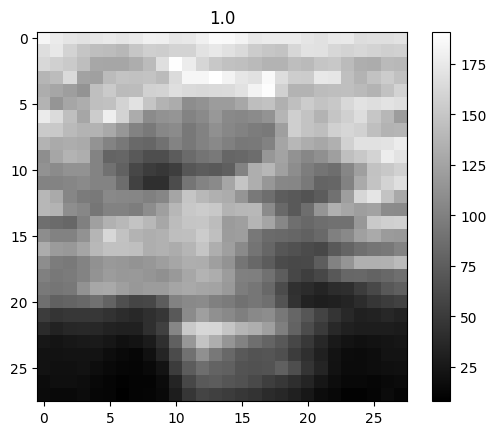

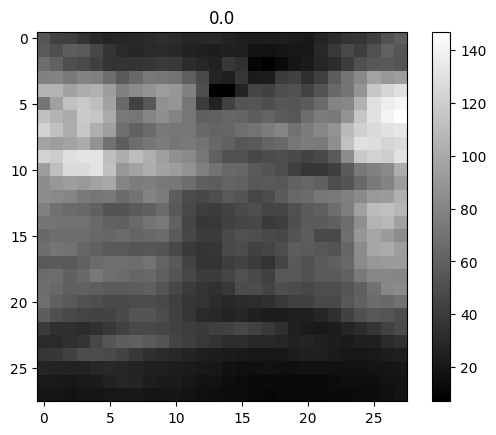

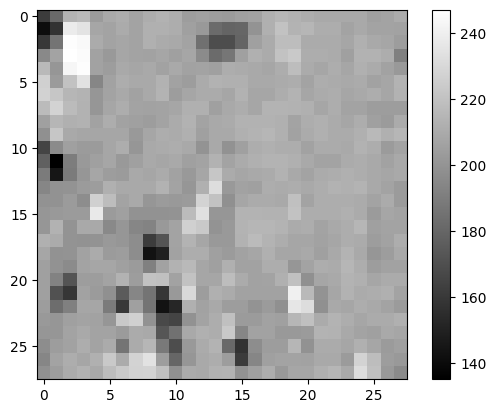

In [ ]:
plt.figure()
plt.title(str(Y_train[2]))
plt.imshow(X_train[2, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure()
plt.title(str(Y_train[-1]))

plt.imshow(X_train[3, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure()
plt.imshow(ood_test[-1, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()


## Create model

In [ ]:
batch_size = 32
img_height = 28
img_width = 28


from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier

class MyModel(models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Rescaling(1./255, input_shape=(28, 28, 1)))
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dropout(.25))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def call(self, inputs):
        return self.model(inputs)

model = MyModel()
model.build(((None,None,None, 1)))

model.summary()




model.compile(optimizer=tf.keras.optimizers.Adam(
              learning_rate=0.0001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
epochs=5

model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=epochs,
)



Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 111137    
                                                                 
Total params: 111,137
Trainable params: 111,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
25/25 [==============================] - 8s 247ms/step - loss: 0.6886 - accuracy: 0.6536 - val_loss: 0.6726 - val_accuracy: 0.9763
Epoch 2/5
25/25 [==============================] - 3s 133ms/step - loss: 0.6535 - accuracy: 0.8312 - val_loss: 0.6310 - val_accuracy: 0.9852
Epoch 3/5
25/25 [==============================] - 4s 160ms/step - loss: 0.5940 - accuracy: 0.8731 - val_loss: 0.5453 - val_accuracy: 0.9793
Epoch 4/5
25/25 [==============================] - 4s 167ms/step - loss: 0.4872 - accuracy: 0.9010 - val_loss: 0.3996 - val_accuracy: 0.9793
Epoch 5/5
25/25 

## Evaluate the model

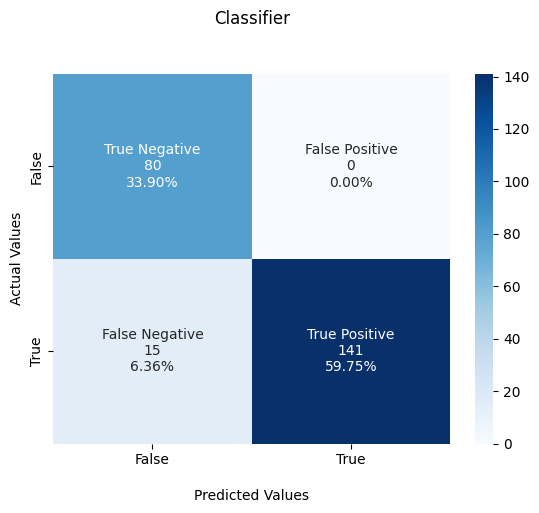

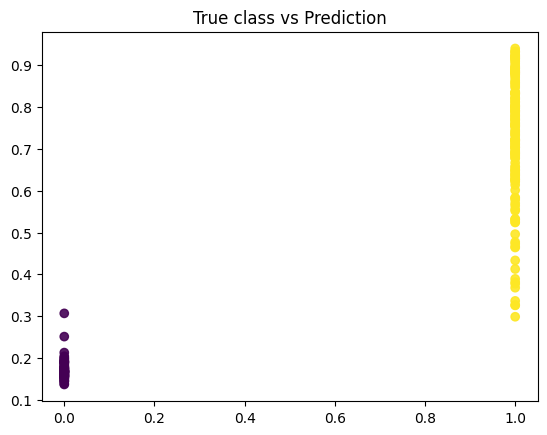

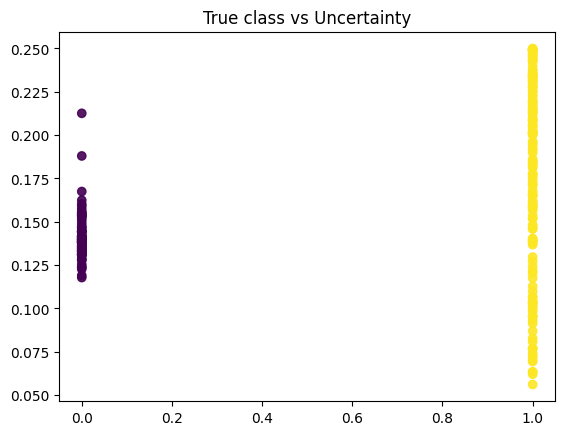

In [ ]:
predictions=model(X_test)
predictions=predictions.numpy()
plot_confusion_matrix(Y_test, predictions)

plt.title('True class vs Prediction')
plt.scatter(Y_test, predictions, c= list(Y_test), alpha=0.9)
plt.show()

plt.title('True class vs Uncertainty')

uncertainty = predictions * (1 - predictions)
plt.scatter(Y_test, uncertainty, c= list(Y_test), alpha=0.9)
plt.show()


### Test model in a sample originating from the test set

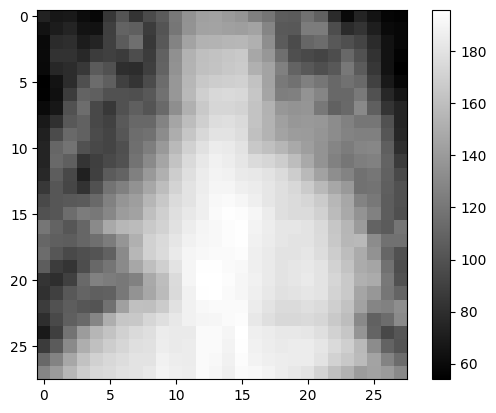

Indistribution sample
[[0.16830355]]
[[0.13997747]]
Rotating image 90 degrees
[[0.29905358]]
[[0.20962055]]
Fliping image upside down
[[0.29898947]]
[[0.20959477]]


In [ ]:
# resnet_uncertainty = resnet_probs * (1 - resnet_probs)
# Get a sample
example_case=10
sample=X_test[example_case, :,:]
plt.figure()
plt.imshow(sample, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample=np.reshape(sample,(1,28,28))
predictions_sample=model(sample)
predictions_sample=predictions_sample.numpy()
print('Indistribution sample')
print(predictions_sample)
uncertainty = predictions_sample * (1 - predictions_sample)
print(uncertainty)
# What if we just rotate?
print('Rotating image 90 degrees')
rot_sample=np.rot90(X_test[example_case, :,:],1).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
print(predictions_sample)
uncertainty = predictions_sample * (1 - predictions_sample)
print(uncertainty)
rot_sample=np.flipud(X_test[example_case, :,:]).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
print('Fliping image upside down')
print(predictions_sample)
uncertainty = predictions_sample * (1 - predictions_sample)
print(uncertainty)

### Test model in out of distribution data (Deterministic Model)

In [ ]:
# resnet_uncertainty = resnet_probs * (1 - resnet_probs)
# Get a sample
sample=ood_test[4, :,:]
sample=np.reshape(sample,(1,28,28))
predictions=model(sample)
predictions=predictions.numpy()
print(predictions)
uncertainty = predictions * (1 - predictions)
print(uncertainty)

[[0.166118]]
[[0.1385228]]


#### Apply to all the OOD and plot uncertainty

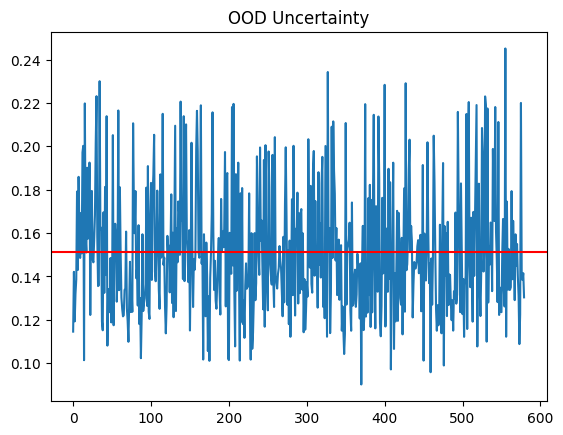

In [ ]:
predictions=model(ood_test)
predictions=predictions.numpy()
uncertainty = predictions * (1 - predictions)
plt.title('OOD Uncertainty')
uncertainty = predictions * (1 - predictions)
plt.plot(uncertainty)
plt.axhline(y=uncertainty.mean(),color = 'r', linestyle = '-')
plt.show()

#### Apply to all the test cases and plot uncertainty

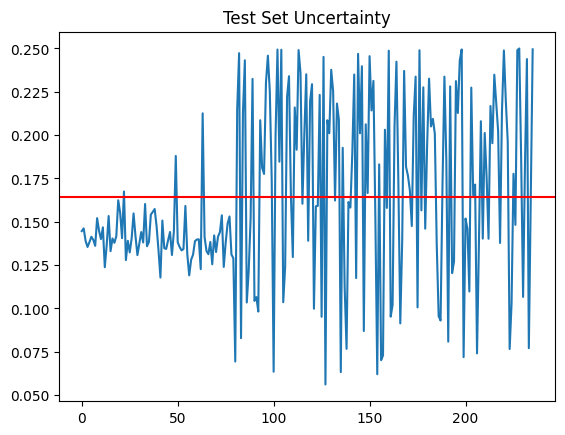

In [ ]:
predictions=model(X_test)
predictions=predictions.numpy()
uncertainty = predictions * (1 - predictions)
plt.title('Test Set Uncertainty')
uncertainty = predictions * (1 - predictions)
plt.plot(uncertainty)
plt.axhline(y=uncertainty.mean(),color = 'r', linestyle = '-')
plt.show()

## Monte Carlo dropout

In [ ]:
num_ensemble = 100
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return model(test_examples, training=True)

### In distribution

In [ ]:
# Get a sample
sample=X_test[0,:,:]
print(f"True Class {Y_test[0]}")
sample=np.reshape(sample,(1,28,28))
dropout_samples = [mc_dropout_sampling(sample).numpy() for _ in range(num_ensemble)]
print(np.array(dropout_samples).mean())
uncertainty = np.array(dropout_samples).mean() * (1 - np.array(dropout_samples).mean())
print(uncertainty)
# Get a sample
sample=X_test[10,:,:]
print(f"True Class {Y_test[10]}")
sample=np.reshape(sample,(1,28,28))
dropout_samples = [mc_dropout_sampling(sample).numpy() for _ in range(num_ensemble)]
print(np.array(dropout_samples).mean())
uncertainty = np.array(dropout_samples).mean() * (1 - np.array(dropout_samples).mean())
print(uncertainty)


True Class 0.0
0.18972908
0.1537319559567114
True Class 0.0
0.20096001
0.16057508455433034


### Out of distribution example

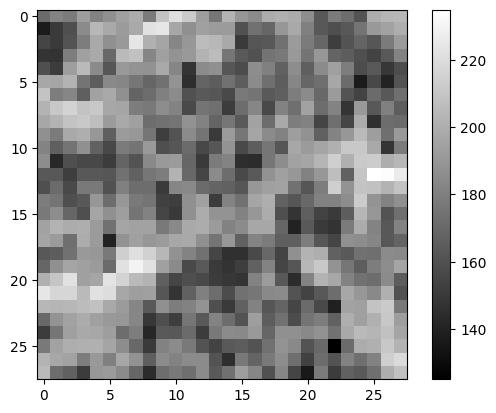

[array([[0.09604686]], dtype=float32), array([[0.38565525]], dtype=float32), array([[0.09740597]], dtype=float32), array([[0.39565212]], dtype=float32), array([[0.5706738]], dtype=float32), array([[0.35940868]], dtype=float32), array([[0.20526661]], dtype=float32), array([[0.10375967]], dtype=float32), array([[0.19281697]], dtype=float32), array([[0.09991862]], dtype=float32), array([[0.10430197]], dtype=float32), array([[0.20736802]], dtype=float32), array([[0.21533737]], dtype=float32), array([[0.56816626]], dtype=float32), array([[0.21415444]], dtype=float32), array([[0.3820076]], dtype=float32), array([[0.21415444]], dtype=float32), array([[0.10430197]], dtype=float32), array([[0.08985487]], dtype=float32), array([[0.37697458]], dtype=float32), array([[0.09991862]], dtype=float32), array([[0.10430197]], dtype=float32), array([[0.08692282]], dtype=float32), array([[0.07809412]], dtype=float32), array([[0.3820076]], dtype=float32), array([[0.17763282]], dtype=float32), array([[0.2048

In [ ]:
plt.figure()
plt.imshow(ood_test[10, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample_ood=ood_test[4,:,:]
sample_ood=np.reshape(sample_ood,(1,28,28))
dropout_samples_ood = [mc_dropout_sampling(sample_ood).numpy() for _ in range(num_ensemble)]
print(dropout_samples_ood)
print(np.array(dropout_samples_ood).mean())
uncertainty = np.array(dropout_samples_ood).mean() * (1 - np.array(dropout_samples_ood).mean())
print(uncertainty)


## Deep Ensemble

In [ ]:
num_ensemble=10
# Deep ensemble training
deep_ensemble = []
import random


for ivar in range(num_ensemble):
  print(f'{ivar}')
  tf.keras.utils.set_random_seed(random.randint(100,1000))
  temp_model= MyModel()
  temp_model.build(((None,None,None, 1)))

  temp_model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
  temp_model.reset_states()
  temp_model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=epochs)
  print(f'------')

  deep_ensemble.append(temp_model)

  del temp_model

0
Epoch 1/5
25/25 [==============================] - 5s 133ms/step - loss: 0.4771 - accuracy: 0.7602 - val_loss: 0.1561 - val_accuracy: 0.9734
Epoch 2/5
25/25 [==============================] - 2s 81ms/step - loss: 0.0917 - accuracy: 0.9530 - val_loss: 0.0367 - val_accuracy: 0.9882
Epoch 3/5
25/25 [==============================] - 2s 68ms/step - loss: 0.0520 - accuracy: 0.9670 - val_loss: 0.0143 - val_accuracy: 0.9911
Epoch 4/5
25/25 [==============================] - 2s 68ms/step - loss: 0.0349 - accuracy: 0.9695 - val_loss: 0.0195 - val_accuracy: 0.9882
Epoch 5/5
25/25 [==============================] - 2s 66ms/step - loss: 0.0374 - accuracy: 0.9657 - val_loss: 0.0333 - val_accuracy: 0.9852
------
1
Epoch 1/5
25/25 [==============================] - 3s 84ms/step - loss: 0.3909 - accuracy: 0.8426 - val_loss: 0.1074 - val_accuracy: 0.9911
Epoch 2/5
25/25 [==============================] - 3s 118ms/step - loss: 0.0617 - accuracy: 0.9860 - val_loss: 0.0321 - val_accuracy: 0.9882
Epoch 3

0.9999054
9.458362350400762e-05


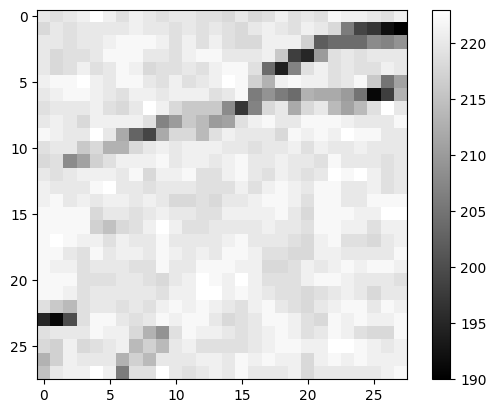

0.0011515927
0.0011502665377813152


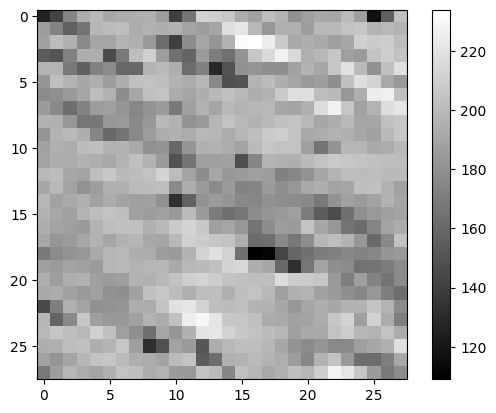

0.0071780495
0.007126525139438664


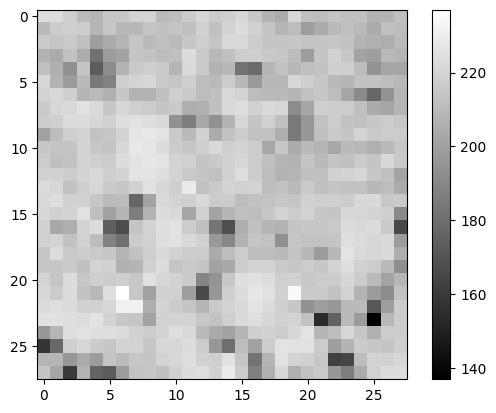

0.0021844106
0.0021796389299227397


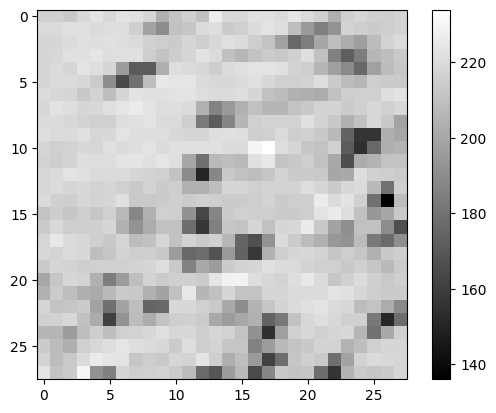

0.004958833
0.004934243076402002


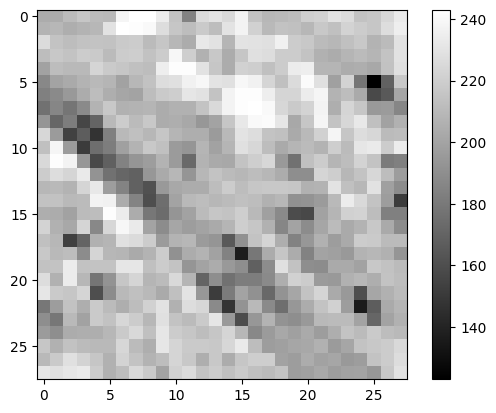

0.0061023496
0.006065110938384452


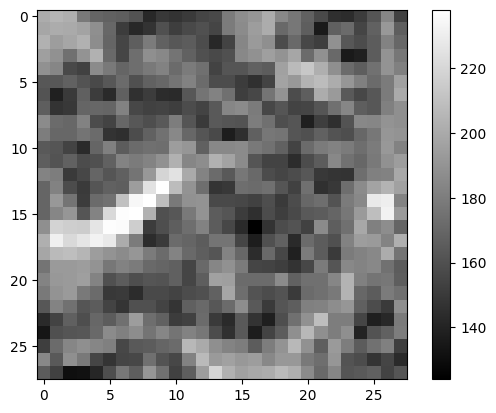

0.0898902
0.0818099494172253


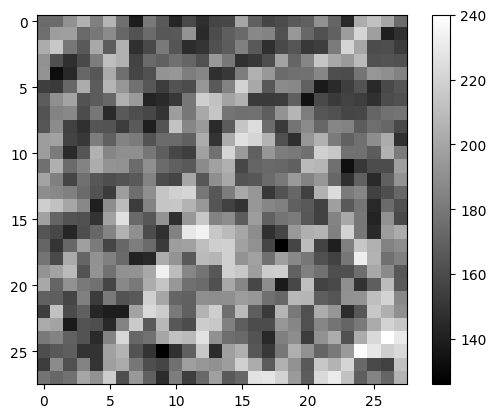

0.022752788
0.02223509855981763


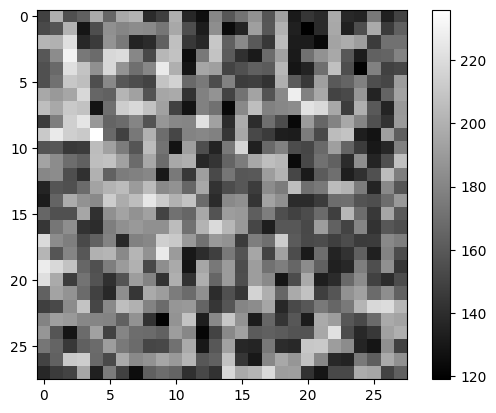

0.22627842
0.17507649897605404


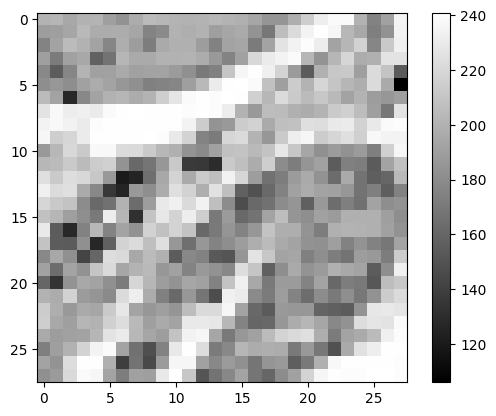

0.047232125
0.045001251326748135


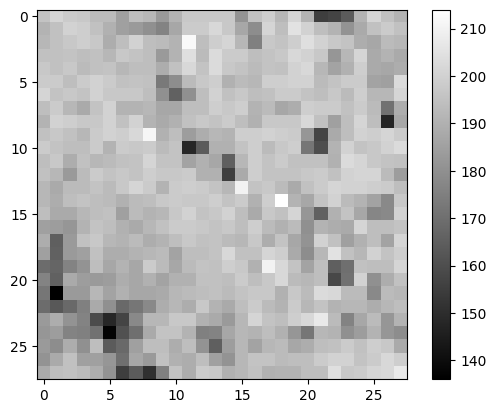

0.009602283
0.00951007928634321


In [ ]:


# Get a sample
sample=X_test[-11,:,:]
sample=np.reshape(sample,(1,28,28))
ensemble_preds_samples = [model_x(sample).numpy() for model_x in (deep_ensemble)]
print(np.array(ensemble_preds_samples).mean())
uncertainty = np.array(ensemble_preds_samples).mean() * (1 - np.array(ensemble_preds_samples).mean())
print(uncertainty)


for i in range(0,10):
  sample_ood=ood_test[i,:,:]
  plt.figure()
  plt.imshow(sample_ood, cmap='gray')
  plt.colorbar()
  plt.grid(False)
  plt.show()
  sample_ood=np.reshape(sample_ood,(1,28,28))
  ensemble_preds_samples_ood = [model_x(sample_ood).numpy() for model_x in (deep_ensemble)]
  print(np.array(ensemble_preds_samples_ood).mean())
  uncertainty = np.array(ensemble_preds_samples_ood).mean() * (1 - np.array(ensemble_preds_samples_ood).mean())
  print(uncertainty)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "simplenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    multiple                  0         
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 conv2d_33 (Conv2D)          multiple                  160       
                                                                 
 max_pooling2d_33 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          multiple                  2320      
                                                                 
 max_pooling2d_34 (MaxPoolin  multiple                 0         
 g2D)                                                    

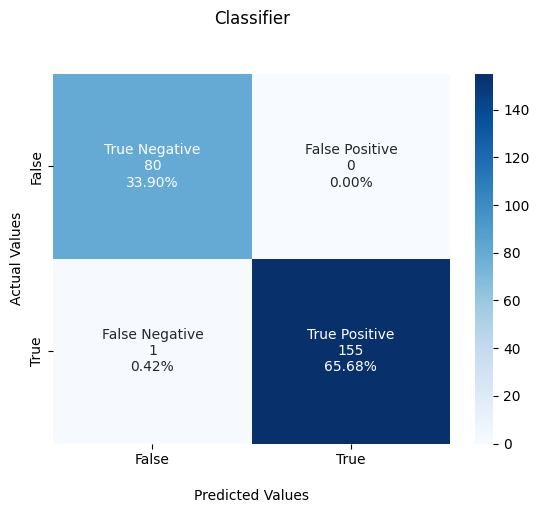

In [ ]:
import official.nlp.modeling.layers as nlp_layers
epochs=10
class simplenet(tf.keras.Model):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes=1, num_layers=1, num_hidden=128,
                 dropout_rate=0.1, **classifier_kwargs):
        super().__init__()
        # Define class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        # Define the layers.
        self.input_layer = tf.keras.layers.Input((None,None))
        self.normalize_layer = tf.keras.layers.Rescaling(1/255.)
        self.reshape_layer = tf.keras.layers.Reshape((28, 28, 1))
        self.conv1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPool2D(2)
        self.conv2 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPool2D(2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(128)

        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]
        self.classifier = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Project the 2D input data to high dimension.
        normalized = self.normalize_layer(inputs)
        reshape_layer=self.reshape_layer(normalized)
        conv1 = self.conv1(reshape_layer)
        maxpool1 = self.maxpool1(conv1)
        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        flattened = self.flatten(maxpool2)
        dense = self.dense(flattened)

        # Compute the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](dense)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            dense += resid

        return self.classifier(dense)

    def make_dense_layer(self):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu")

    def make_output_layer(self, num_classes):
        """Use the Dense layer as the output layer."""
        return tf.keras.layers.Dense(
            num_classes, activation="sigmoid", **self.classifier_kwargs)



simple_model = simplenet()
simple_model.build((None, None))
simple_model.summary()
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.BinaryAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

simple_model.compile(**train_config)
simple_model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=epochs)
plot_confusion_matrix(Y_test, simple_model(X_test))

Text(0.5, 1.0, 'Test Set')

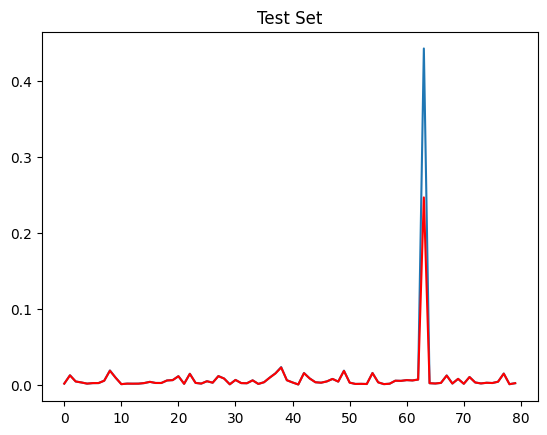

In [ ]:
test_filter = np.where((Y_test == 0))
X_test_0=X_test[test_filter]
output = simple_model(X_test_0)
plt.plot(output)
uncertainty = output * (1. - output)
plt.plot(uncertainty, c='r')
plt.title('Test Set')

In [ ]:
class simplenetSNGP(simplenet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits
config = dict(num_classes=1)
# sngp_model = simplenetSNGP(**resnet_config)
# sngp_model.build((None, None))
# sngp_model.summary()




class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()
class DeepResNetSNGPWithCovReset(simplenetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)
sngp_model = simplenetSNGP(**config)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.BinaryAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
sngp_model.compile(**train_config)
sngp_model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=epochs)

Epoch 1/10
25/25 [==============================] - 5s 77ms/step - loss: 3.5148 - binary_accuracy: 0.5165 - val_loss: 0.9146 - val_binary_accuracy: 0.5118
Epoch 2/10
25/25 [==============================] - 1s 50ms/step - loss: 0.7977 - binary_accuracy: 0.5165 - val_loss: 0.7074 - val_binary_accuracy: 0.5118
Epoch 3/10
25/25 [==============================] - 1s 33ms/step - loss: 0.6560 - binary_accuracy: 0.5165 - val_loss: 0.6043 - val_binary_accuracy: 0.5118
Epoch 4/10
25/25 [==============================] - 1s 33ms/step - loss: 0.5853 - binary_accuracy: 0.5165 - val_loss: 0.5408 - val_binary_accuracy: 0.5118
Epoch 5/10
25/25 [==============================] - 1s 31ms/step - loss: 0.5113 - binary_accuracy: 0.5165 - val_loss: 0.4764 - val_binary_accuracy: 0.5118
Epoch 6/10
25/25 [==============================] - 1s 33ms/step - loss: 0.4504 - binary_accuracy: 0.5254 - val_loss: 0.4129 - val_binary_accuracy: 0.6213
Epoch 7/10
25/25 [==============================] - 1s 30ms/step - los

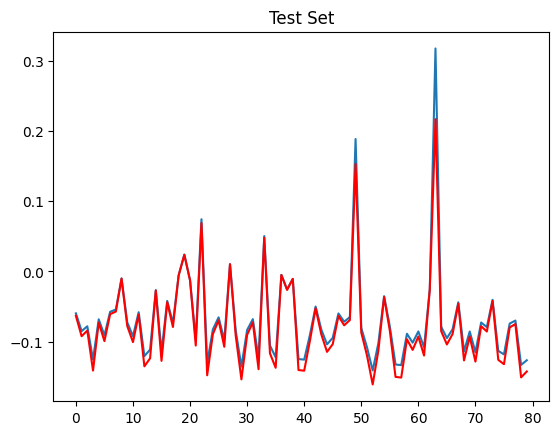

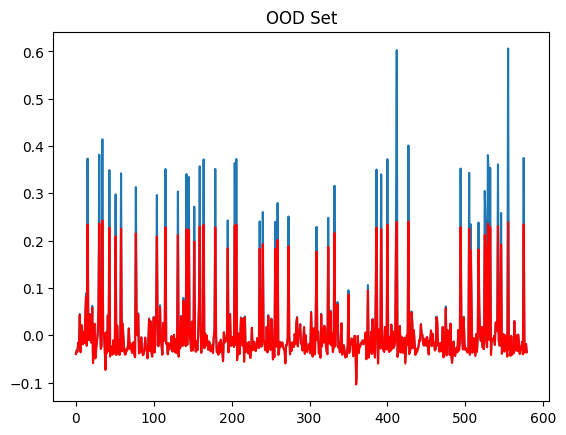

In [ ]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return logits_adjusted


test_filter = np.where((Y_test == 0))
X_test_0=X_test[test_filter]
sngp_logits, sngp_covmat = sngp_model(X_test_0, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

plt.plot(sngp_probs)
uncertainty = sngp_probs * (1. - sngp_probs)

plt.plot(uncertainty, c='r')
plt.title('Test Set')
plt.show()

sngp_logits_ood, sngp_covmat_ood = sngp_model(ood_test, return_covmat=True)
sngp_probs_ood = compute_posterior_mean_probability(sngp_logits_ood, sngp_covmat_ood)

plt.plot(sngp_probs_ood)
uncertainty = sngp_probs_ood * (1. - sngp_probs_ood)

plt.plot(uncertainty, c='r')
plt.title('OOD Set')
plt.show()